Instead of looking at the raw corpus, I would like to use a tf-idf matrix along with different forms of dimensionality reduction to then classify based on review scores in order to tag each review with sentiment. Hopefully, this will allow me to get more precise sentiment scores (slightly positive, very positive etc.)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pyfuncs import text_funcs
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
Xy = pd.read_pickle('laptop_Xy.pkl')
X, y = Xy.iloc[:, 1:], Xy['review_ratings'] #tfidf vectorized corpus
X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's try PCA first.

In [13]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= .95) + 1

In [14]:
d

361

In [15]:
X_train.shape

(450, 3971)

wow! just 361 dimensions can describe 95% of the variance. let's see how well a variety of classification algorithms do. 

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#let's say 5 classes, one for each review rating
knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.25      0.33        12
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       0.29      0.12      0.17        43
           5       0.59      0.92      0.72        78

    accuracy                           0.53       150
   macro avg       0.28      0.26      0.24       150
weighted avg       0.43      0.53      0.45       150



/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
def get_stacked_ytrue_ypred(y_test, y_pred):
    class_df = pd.DataFrame({'ytrue': y_test, 'ypred': y_pred})
    class_df.ytrue = class_df.ytrue.astype(int)
    class_df.ypred = class_df.ypred.astype(int)
    class_1 = class_df.loc[class_df['ypred']==1, :]['ytrue'].value_counts()
    class_2 = class_df.loc[class_df['ypred']==2, :]['ytrue'].value_counts()
    class_3 = class_df.loc[class_df['ypred']==3, :]['ytrue'].value_counts()
    class_4 = class_df.loc[class_df['ypred']==4, :]['ytrue'].value_counts()
    class_5 = class_df.loc[class_df['ypred']==5, :]['ytrue'].value_counts()
    df_plot = pd.DataFrame([class_1, class_2, class_3, class_4, class_5])
    ax = df_plot.plot(kind='bar', stacked=True)
    ax.set_xticklabels([1,2,3,4,5])
    plt.xlabel('predicted class')
    plt.ylabel('count of predicted class')
    plt.legend()

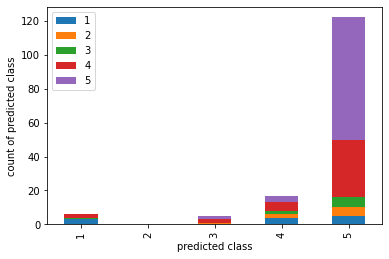

In [18]:
get_stacked_ytrue_ypred(y_test, y_pred)

That worked well, but I'll definitely have to go back and scrape more text data so that I can populate the underepresented review rating classes. Next I'll try using a gaussian naive bayes classifier on this projected tfidf dataset.

In [19]:
from sklearn.naive_bayes import GaussianNB
cnb = GaussianNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.17      0.25        12
           2       0.00      0.00      0.00         8
           3       0.50      0.11      0.18         9
           4       0.50      0.19      0.27        43
           5       0.57      0.91      0.70        78

    accuracy                           0.55       150
   macro avg       0.41      0.27      0.28       150
weighted avg       0.51      0.55      0.47       150



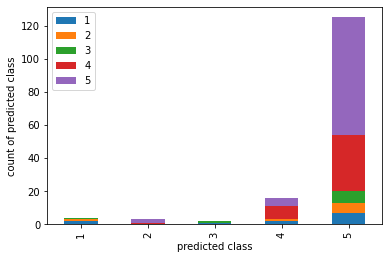

In [20]:
get_stacked_ytrue_ypred(y_test, y_pred)

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.17      0.29        12
           2       0.00      0.00      0.00         8
           3       1.00      0.11      0.20         9
           4       0.55      0.14      0.22        43
           5       0.57      1.00      0.73        78

    accuracy                           0.58       150
   macro avg       0.62      0.28      0.29       150
weighted avg       0.59      0.58      0.48       150



/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


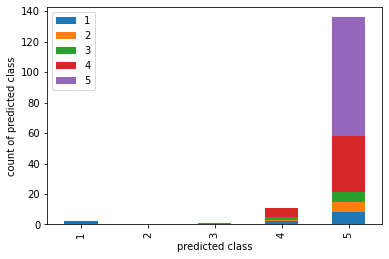

In [22]:
get_stacked_ytrue_ypred(y_test, y_pred)

Now let's take a look at different kernels for PCA along with logistic regression.

In [23]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
    ('kpca', KernelPCA()),
    ('log', LogisticRegression())
])

param_grid = [{
    "kpca__n_components": [200,300,350,400,500],
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ['linear', 'rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA()),
                                       ('log', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['linear', 'rbf', 'sigmoid'],
                          'kpca__n_components': [200, 300, 350, 400, 500]}])

In [24]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear', 'kpca__n_components': 300}

In [25]:
log_reg_pipeline = grid_search.best_estimator_
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       1.00      0.08      0.15        12
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       0.33      0.07      0.12        43
           5       0.54      0.97      0.70        78

    accuracy                           0.53       150
   macro avg       0.38      0.23      0.19       150
weighted avg       0.46      0.53      0.41       150



/home/dyllanjr/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


That's pretty interesting, but now I'd like to see if I can project down to 2d while minimizing reconstruction error so that I could get a visual of the seperability of the classes.

In [26]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X_train)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_train, X_preimage)

3.910843565053899e-32

In [28]:
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('logreg', LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ['linear', 'rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('logreg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['linear', 'rbf', 'sigmoid']}],
             scoring='neg_mean_squared_error')

In [29]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}

In [30]:
kpca = KernelPCA(n_components=2, gamma=.03, kernel='rbf')
X_reduced = kpca.fit_transform(X_train)

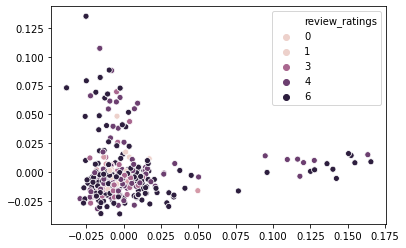

In [31]:
sns.scatterplot(X_reduced[:,0], X_reduced[:,1], hue=y_train)

In [32]:
y_train.value_counts()

5    238
4    117
3     37
1     30
2     28
Name: review_ratings, dtype: int64